# Analyse Full spectrum calibration

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : September 7th  2023
- last update : September 7th 2023



- adapted from https://github.com/sylvielsstfr/AuxTelComm/blob/main/notebookccdm_gen3/order2order1/anaFullSpectrumCalib.ipynbhttps://github.com/sylvielsstfr/AuxTelComm/blob/main/notebookccdm_gen3/order2order1/anaFullSpectrumCalib.ipynb


Implemented at USDF

Must install **atmosphtransmemullsst** at https://github.com/LSSTDESC/atmosphtransmemullsst


- do git clone
- python -m pip install . --user

# Imports

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

from astropy import units as u

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 8),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


In [3]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [4]:
from scipy import interpolate

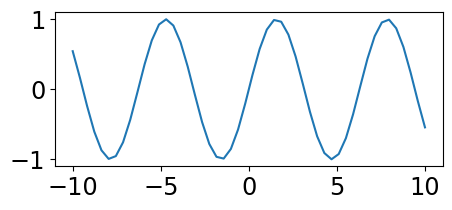

In [5]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [6]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [7]:
from datetime import datetime,date

In [8]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [9]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [10]:
string_date

'2023-09-07'

In [11]:
from iminuit import Minuit
import iminuit

In [12]:
iminuit.__version__

'2.22.0'

In [13]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor import dispersers
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines,calibrate_spectrum
from spectractor.extractor.spectrum import *
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, HGAMMA, HDELTA,HEPSILON,O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

### atmosphtransmemullsst

In [14]:
path_atmosphtransmemullsst = "../../../atmosphtransmemullsst/atmosphtransmemullsst"

In [15]:
sys.path.append(path_atmosphtransmemullsst)

In [16]:
from importlib.metadata import version
the_ver = version('atmosphtransmemullsst')
print(f"Version of atmosphtransmemullsst : {the_ver}")

Version of atmosphtransmemullsst : 0.0.1


In [17]:
import atmosphtransmemullsst
from atmosphtransmemullsst.simpleatmospherictransparencyemulator import SimpleAtmEmulator

In [18]:
emul = SimpleAtmEmulator(os.path.join(atmosphtransmemullsst.__path__[0],'/home/d/dagoret/rubin-user/atmosphtransmemullsst/data/simplegrid'))

SimpleAtmEmulator:path=/home/d/dagoret/rubin-user/atmosphtransmemullsst/data/simplegrid


In [19]:
#import libsimulateVisible

In [20]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [21]:
from time import sleep

In [22]:
from astropy.time import Time
import astropy.units as u

In [23]:
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

In [24]:
DCCD   = 181.45 # mm
#DCCD   = 200.0 # mm
PIXELW = 0.01   # mm (10 microns)

## Dispersion relation X - wavelength
$$
x = D \frac{N_{eff} \lambda p}{\sqrt{1-(N_{eff} \lambda p)^2}}
$$

In [25]:
def Dispersion(wl,neff,D,p=1):
    """ 
    Dispersion(wl,a,D) : number of dx per wavelength
    input arguments:
    - wl : wavelength in mm
    - neff  : number of lines per mm
    - D  : Distance CCD-Hologram per mm
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx, x in mm and lambdas in mm
    """
    X=D*neff*wl*p/np.sqrt(1-(wl*neff*p)**2)
    return X


## Dispersion rate dX/d lambda
$$
\frac{dx}{d\lambda} = D N_{eff} p \frac{\sqrt{1-(N_{eff}\lambda p)^2} + \frac{(N_{eff} \lambda p)^2}{\sqrt{1-(N_{eff} \lambda p)^2} }}{1-(N_{eff} \lambda p)^2} 
$$

$$
\frac{dx}{d\lambda} = \frac{D N_{eff} p}{\left(1-(N_{eff} \lambda p)^2\right)^{\frac{3}{2}}} 
$$

$$
\frac{dx}{d\lambda}\frac{D N_{eff} p}{\left(1-(N_{eff} \lambda p)^2\right)^{\frac{3}{2}} 
$$

In [26]:
def Dispersion_Rate(wl,neff,D,p=1):
    """
    Dispersion_Rate(wl) : number of dx per wavelength
    input arguments:
    - wl : wavelength in mm
    - neff  : nb lines per mm 
    - D  : Distance CCD-Hologram in mm
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx/dlambda, x in mm and lambdas in mm
    
    """
    #dxdlambda=D*neff*p*(np.sqrt(1-(wl*neff*p)**2)+ (wl*neff*p)**2/np.sqrt(1-(wl*neff*p)**2))/(1-(wl*neff*p)**2)
   
    dxdlambda=D*neff*p/(np.sqrt(1-(wl*neff*p)**2))**3
    return dxdlambda 

## Choice of Auxtel/Hologram parameters

In [27]:
neff=156. # lines per mm
D=184.45 # mm

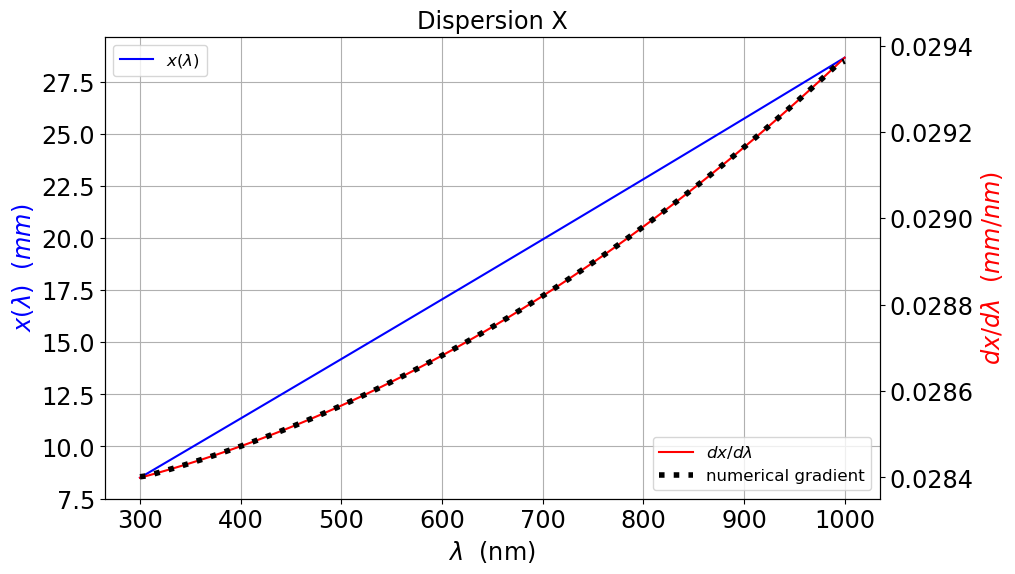

In [28]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(10,6))
WL=np.linspace(300.,1000.,100)

Y1=Dispersion(WL*1e-6,neff,DCCD)
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  ($mm$)",color="blue")
ax1.set_title("Dispersion X")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

Y2=Dispersion_Rate(WL*1e-6,neff,DCCD)*1e-6 ## mm per nm
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.plot(WL,np.gradient(Y1,WL),"k:",lw=4,label="numerical gradient")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($mm/ nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()


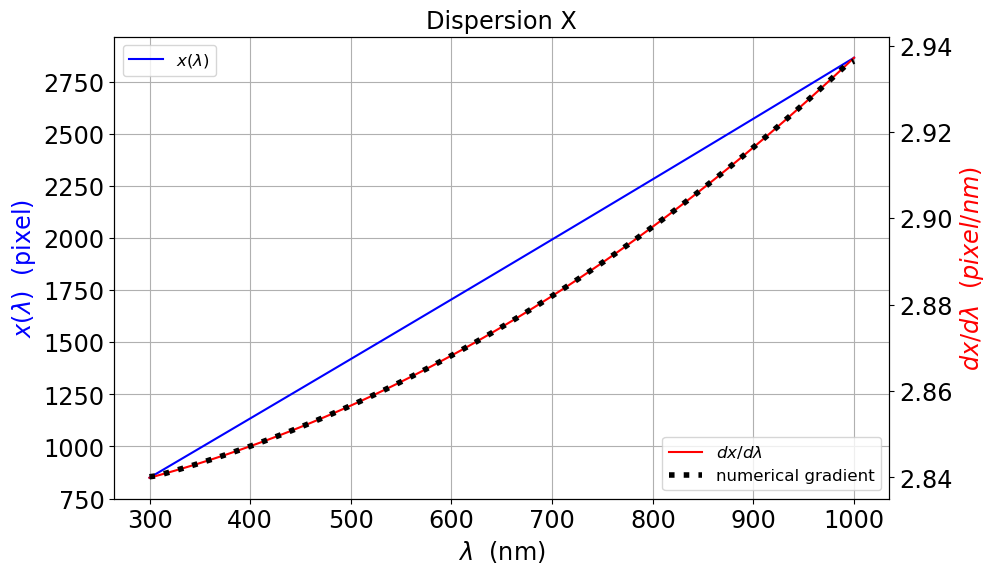

In [29]:
%matplotlib inline
fig, ax1 = plt.subplots(figsize=(10,6))

Y1=Dispersion(WL*1e-6,neff,DCCD)/PIXELW   # pixel
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  (pixel)",color="blue")
ax1.set_title("Dispersion X")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

Y2=Dispersion_Rate(WL*1e-6,neff,DCCD)/PIXELW*1e-6   # pixel per nm
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.plot(WL,np.gradient(Y1,WL),"k:",lw=4,label="numerical gradient")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($pixel/nm$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()

# Function

In [30]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^exposure_.*([0-9][0-9][0-9][0-9][0-9])_postisrccd.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None


In [31]:
def subdir_tag_forsorting(subdir):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('.*([0-9][0-9][0-9][0-9][0-9])$', subdir)
    if len(m)>0:
        return m[0]
    else:
        return None


In [32]:
file_tag_forsorting('exposure_2022031600330_postisrccd.fits')

'00330'

In [33]:
subdir_tag_forsorting('2022031600330')

'00330'

# Config

In [34]:
# path index for each month
DATE="20230817"
#DATE="20211104"
filterdispersername = "empty~holo4_003"
#filterdispersername = "empty~holo4_001"
#filterdispersername = "BG40~holo4_003"
#filterdispersername = "FELH0600~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"

## load parameters from auxtel configuration

In [35]:
load_config("../runspectractor_standalone/2023_09/config/auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini")

In [36]:
parameters.debug=True
parameters.verbose=True
parameters.display=True

# Input file


In [37]:
!ls /home/d/dagoret/rubin-user/DATA/AuxtelData2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230817 

2023081700144  2023081700147  2023081700148  2023081700166


In [38]:
DATE

'20230817'

In [39]:
top_path = "/home/d/dagoret/rubin-user/DATA/AuxtelData2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023"
path = os.path.join(top_path,DATE)

In [40]:
exposure ="2023081700144"  
filename_spectrum = f"exposure_{exposure}_pseudo-postisrccd_spectrum.fits"

In [41]:
path=os.path.join(path,exposure)

In [42]:
path

'/home/d/dagoret/rubin-user/DATA/AuxtelData2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230817/2023081700144'

In [43]:
path_subdir=os.path.join(path,"basespec")
path_subdir

'/home/d/dagoret/rubin-user/DATA/AuxtelData2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230817/2023081700144/basespec'

In [44]:
all_files = sorted(os.listdir(path_subdir))

In [45]:
all_files 

['exposure_2023081700144_pseudo-postisrccd_spectrum.fits']

## Work with spectractor table

In [46]:
print("CCD REBIN",parameters.CCD_REBIN)

CCD REBIN 2


In [47]:
REBIN = parameters.CCD_REBIN

In [48]:
REBIN

2

In [49]:
#table = pd.read_csv(os.path.join(path_subdir,all_files[-1]))
spectrum = Spectrum(file_name=os.path.join(path_subdir,all_files[0]))
table = spectrum.chromatic_psf.table

In [50]:
table = table.to_pandas()

Text(0.5, 1.0, 'Table : wavelength calib in Spectractor')

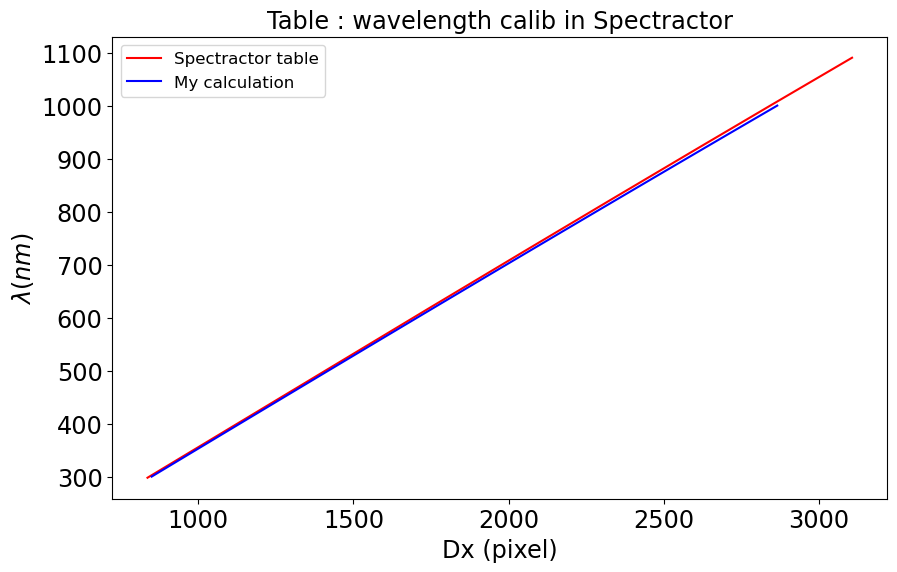

In [51]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(table.Dx*REBIN,table.lambdas,"r-",label="Spectractor table")
ax.plot(Y1,WL,"b-",label="My calculation")
ax.set_xlabel("Dx (pixel)")
ax.set_ylabel("$\lambda (nm)$")
ax.legend()
ax.set_title("Table : wavelength calib in Spectractor")

Text(0.5, 1.0, 'wavelength calib in Spectractor table')

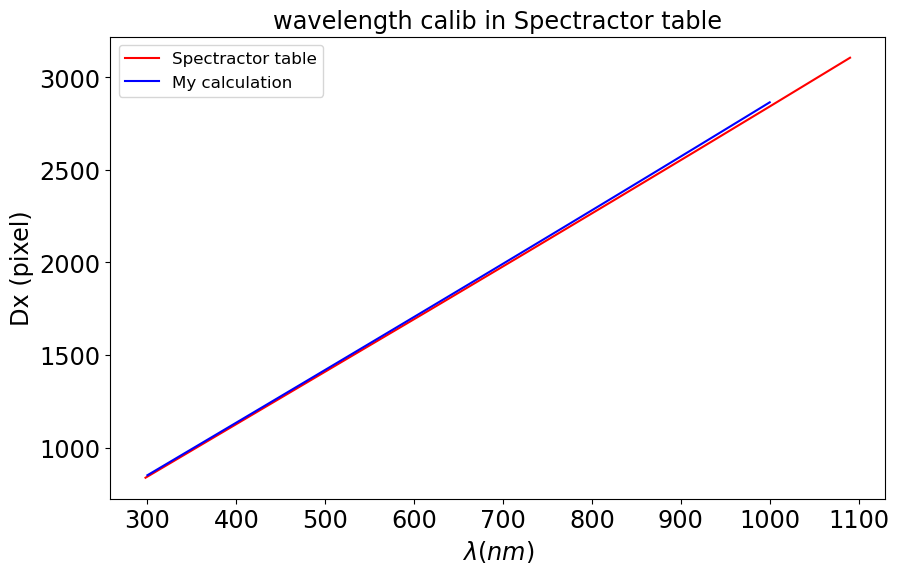

In [52]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(table.lambdas,table.Dx*REBIN,"r-",label="Spectractor table")
ax.plot(WL,Y1,"b-",label="My calculation")
ax.set_ylabel("Dx (pixel)")
ax.set_xlabel("$\lambda (nm)$")
ax.legend()
ax.set_title("wavelength calib in Spectractor table")

Text(0.5, 1.0, 'wavelength calib in Spectractor table')

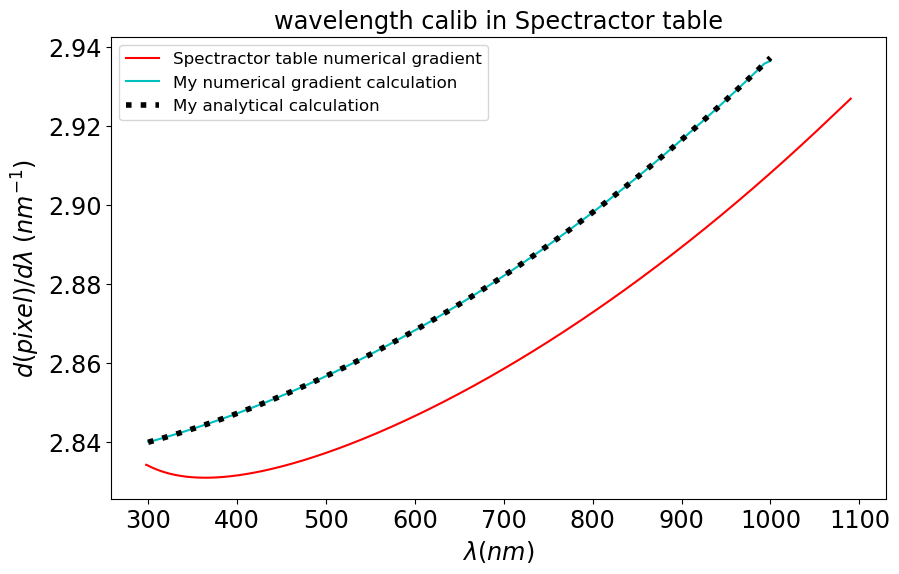

In [53]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(table.lambdas,np.gradient(table.Dx*REBIN,table.lambdas),"r-",label="Spectractor table numerical gradient")
ax.plot(WL,np.gradient(Y1,WL),"c-",label="My numerical gradient calculation")
ax.plot(WL, Y2,"k:",lw=4,label="My analytical calculation")
ax.set_ylabel("$d(pixel)/d\lambda \; (nm^{-1})$")
ax.set_xlabel("$\lambda (nm)$")
ax.legend()
ax.set_title("wavelength calib in Spectractor table")

Text(0.5, 1.0, 'Spectrum from spectrum.chromatic_psf.table')

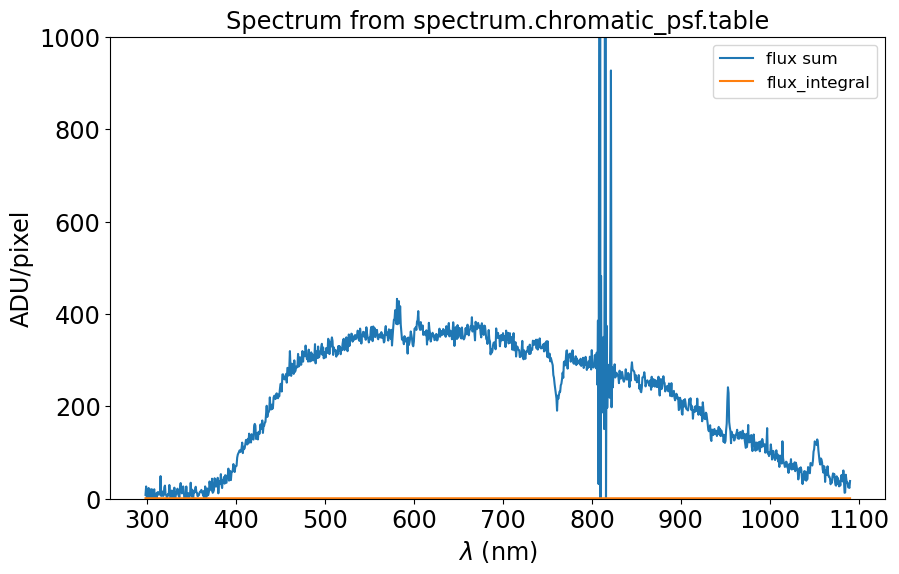

In [54]:
%matplotlib inline
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
ax.plot(table.lambdas,table.flux_sum,label="flux sum")
ax.plot(table.lambdas,table.flux_integral,label="flux_integral")
ax.legend()
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("ADU/pixel")
ax.set_ylim(0,1000)
ax.set_title("Spectrum from spectrum.chromatic_psf.table")

## Spectrum

In [55]:
spectrum = Spectrum(file_name=os.path.join(path_subdir,all_files[0]))

In [56]:
spectrum.airmass

1.903331368739209

[Errno 2] No such file or directory: './figures_process_20230817_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_1/HD185975_spectrum.pdf'


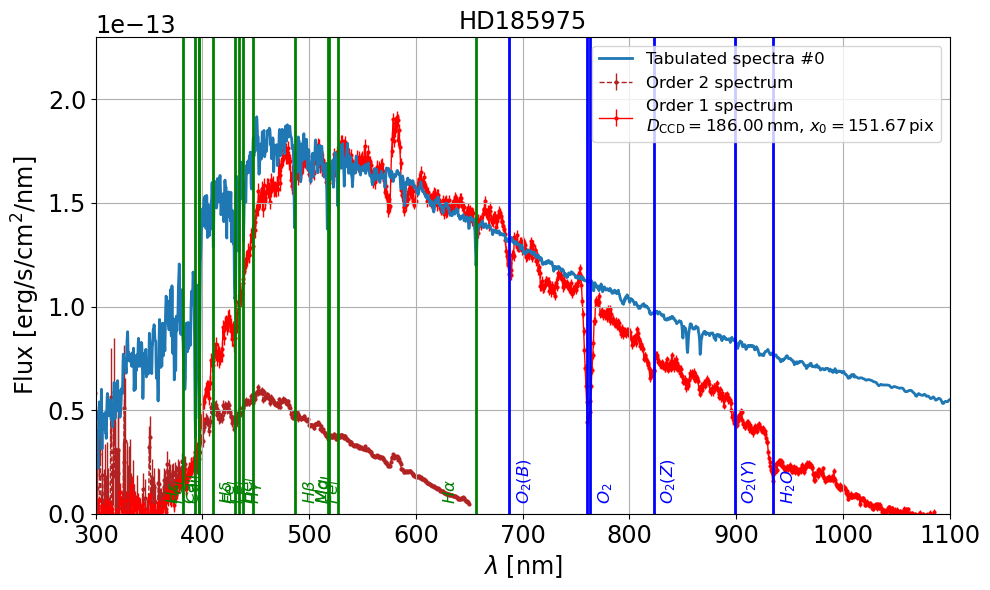

In [57]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
try:
    spectrum.plot_spectrum(xlim=[300,1100], live_fit=False, force_lines=True,ax=ax)
except Exception as exc:
    print(exc)

In [58]:
spectrum.target.load_spectra()

<Figure size 1000x600 with 0 Axes>

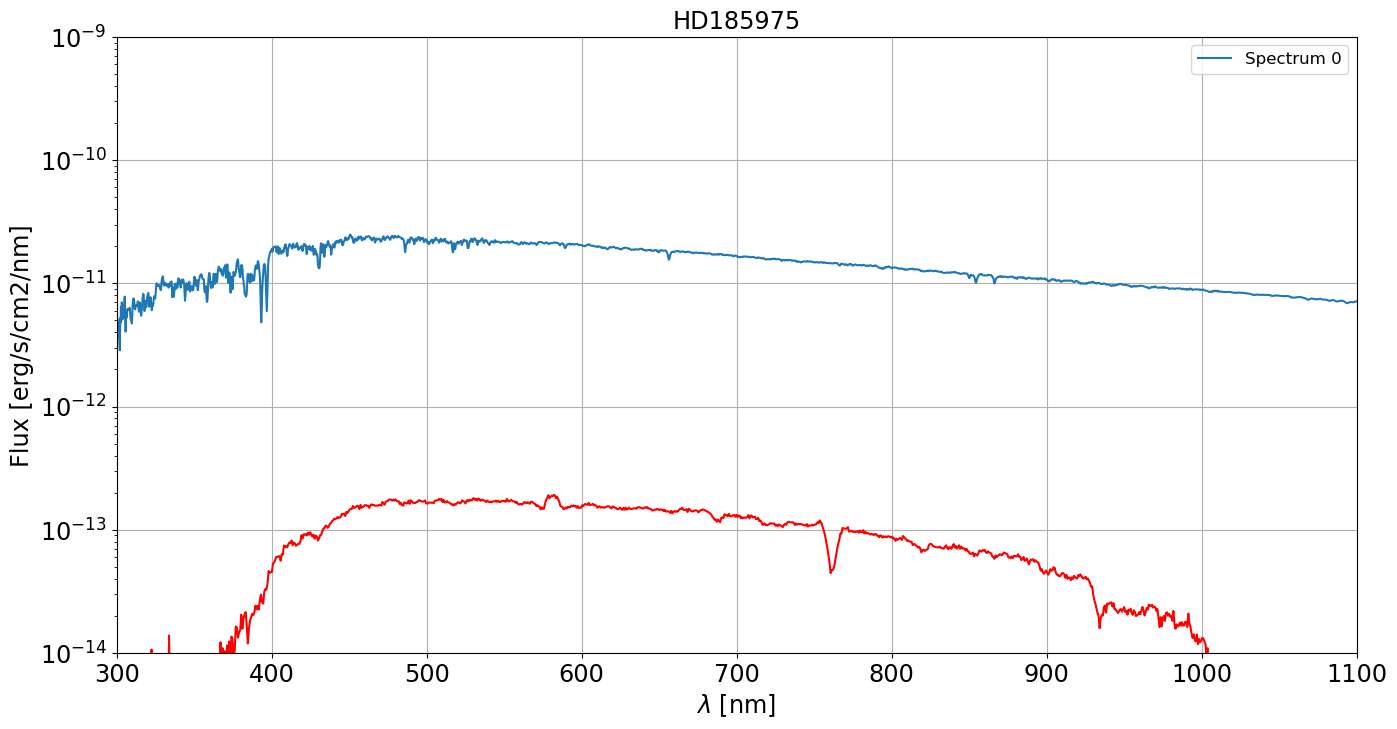

In [59]:
%matplotlib inline
fig=plt.figure(figsize=(10,6))
spectrum.target.plot_spectra()
plt.plot(spectrum.lambdas,spectrum.data,'r-',label="Spectractor Spectrum")
#plt.plot(spectrum.lambdas,spectrum.data*6,'r:')
plt.yscale("log")
plt.ylim(1e-14,1e-9)
plt.grid()

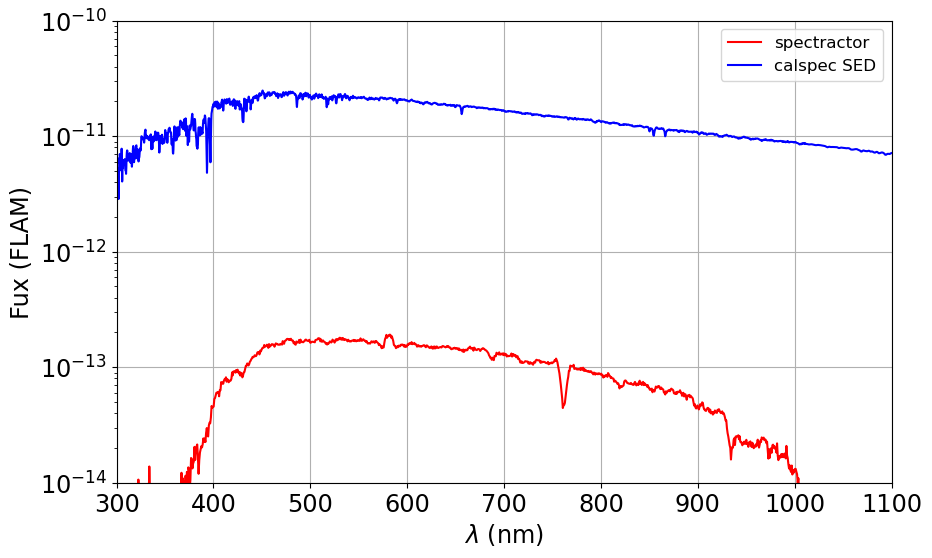

In [60]:
%matplotlib inline
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
#spectrum.target.plot_spectra()

#ax.plot
ax.plot(spectrum.lambdas,spectrum.data,'r-',label="spectractor")
ax.plot(spectrum.target.wavelengths[0],spectrum.target.spectra[0],'b-',label="calspec SED")
ax.set_ylim(1e-14,1e-10)
ax.set_yscale("log")
ax.set_xlim(300.,1100)
ax.legend()
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("Fux (FLAM)")
ax.grid()

In [61]:
f_sed = interpolate.interp1d(spectrum.target.wavelengths[0],spectrum.target.spectra[0],bounds_error=False,fill_value="extrapolate")
f_spec = interpolate.interp1d(spectrum.lambdas,spectrum.data,bounds_error=False,fill_value="extrapolate")

## Simulate atmosphere

In [62]:
am       = spectrum.airmass
pwv      = 4.0
ozone    = 300.

In [63]:
indexes_wl = np.where(spectrum.lambdas>300)[0]
wl = spectrum.lambdas[indexes_wl]
atm = emul.GetAllTransparencies(wl,am,pwv,ozone)

Text(0.5, 1.0, 'atmospheric transmission')

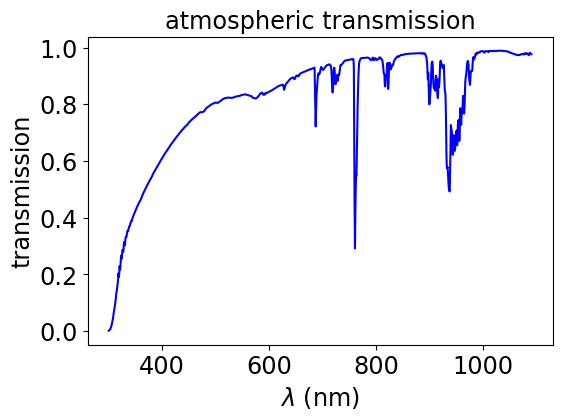

In [64]:
%matplotlib inline
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.plot(wl,atm,"b-")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("transmission")
ax.set_title("atmospheric transmission")

In [65]:
f_atm = interpolate.interp1d(wl,atm,bounds_error=False,fill_value="extrapolate")

### Throughput

In [66]:
!ls /home/d/dagoret/rubin-user/AuxTelComm/notebooks_usdf/FitThrouput/202307/dataout/throughput-2023-01-18-empty~holo4_003-psf2dffm-multifitatmparams-polar.csv

/home/d/dagoret/rubin-user/AuxTelComm/notebooks_usdf/FitThrouput/202307/dataout/throughput-2023-01-18-empty~holo4_003-psf2dffm-multifitatmparams-polar.csv


In [67]:
filename_throughput = "/home/d/dagoret/rubin-user/AuxTelComm/notebooks_usdf/FitThrouput/202307/dataout/throughput-2023-01-18-empty~holo4_003-psf2dffm-multifitatmparams-polar.csv"

In [68]:
dft = pd.read_csv(filename_throughput,index_col=0)

In [69]:
dft = pd.read_csv(filename_throughput)
dft.reset_index(inplace=True)
dft['index'] = dft.reset_index().index
dft.set_index('index')
dft.rename(columns={'wavelength':'lambdas','newthrou':'throughput'},inplace = True)

Text(0.5, 1.0, 'auxtel throughput')

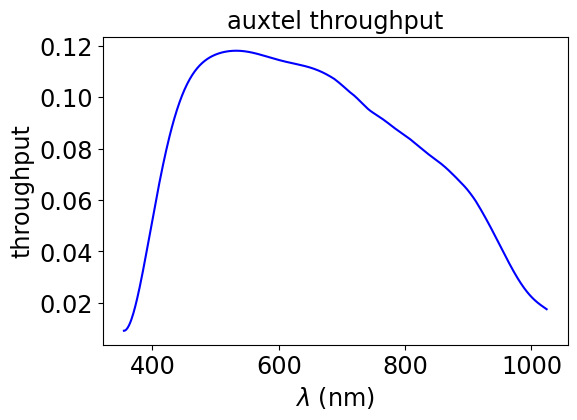

In [70]:
%matplotlib inline
fig=plt.figure(figsize=(6,4))
ax=fig.add_subplot(111)
ax.plot(dft.lambdas,dft.throughput,"b-")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("throughput")
ax.set_title("auxtel throughput")

In [71]:
f_thr = interpolate.interp1d(dft.lambdas,dft.throughput,bounds_error=False,fill_value="extrapolate")

# SED x Throughput x Atmosphere

In [72]:
WL2 = np.arange(300.,1050.)

flux_predicted = f_sed(WL2) * f_thr(WL2) * f_atm(WL2) 
flux_measured  = f_spec(WL2)

Text(0, 0.5, ' Flux (FLAM)')

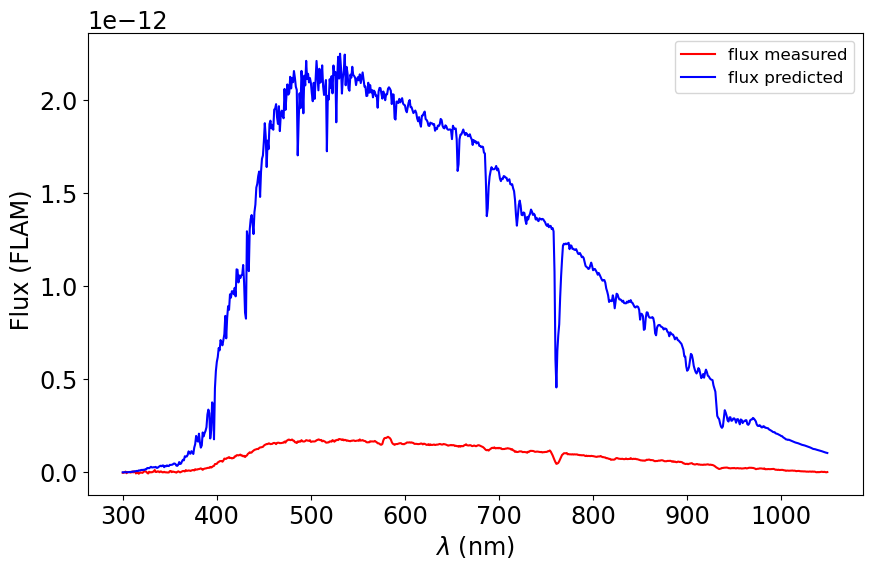

In [73]:
%matplotlib inline
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)

ax.plot(WL2,flux_measured,'r-',label= "flux measured")
ax.plot(WL2,flux_predicted,'b-',label= "flux predicted")
ax.legend()
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel(" Flux (FLAM)")

In [74]:
ratio_s = flux_measured/flux_predicted
ratio_filtered_s = savgol_filter(ratio_s, 31, 3) # window size 51, polynomial order 3

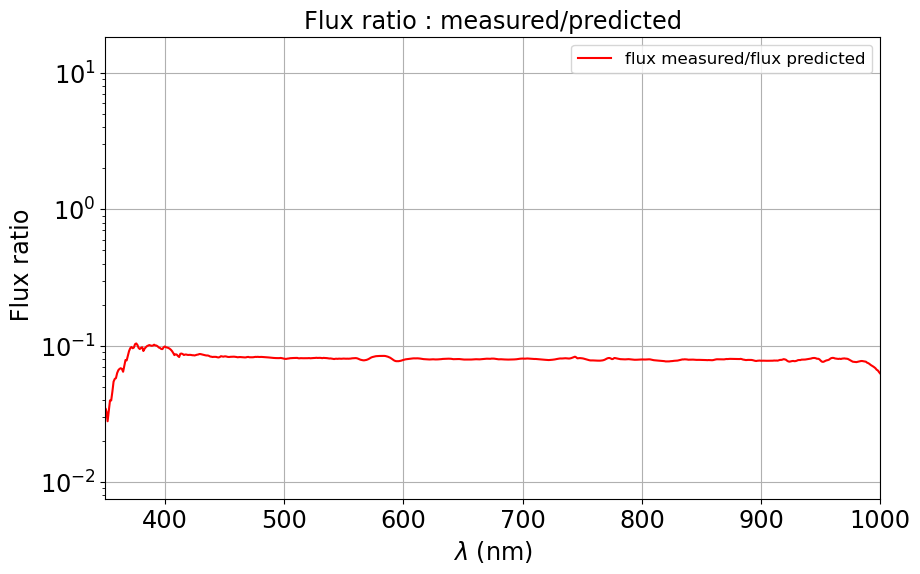

In [75]:
%matplotlib inline
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)

ax.plot(WL2,ratio_filtered_s,'r-',label= "flux measured/flux predicted")
ax.legend()
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel(" Flux ratio")
ax.set_xlim(350.,1000.)
ax.set_yscale("log")
ax.set_title("Flux ratio : measured/predicted")
ax.grid()

# Pixel Wavelength calibration

In [76]:
spectrum.x0

[151.67342663925993, 875.1546112590315]

In [77]:
spectrum.order

1

In [78]:
spectrum.disperser.full_name

'Phase hologram #4-003'

Text(0.5, 1.0, 'Hologram transmissions and ratios in Spectractor')

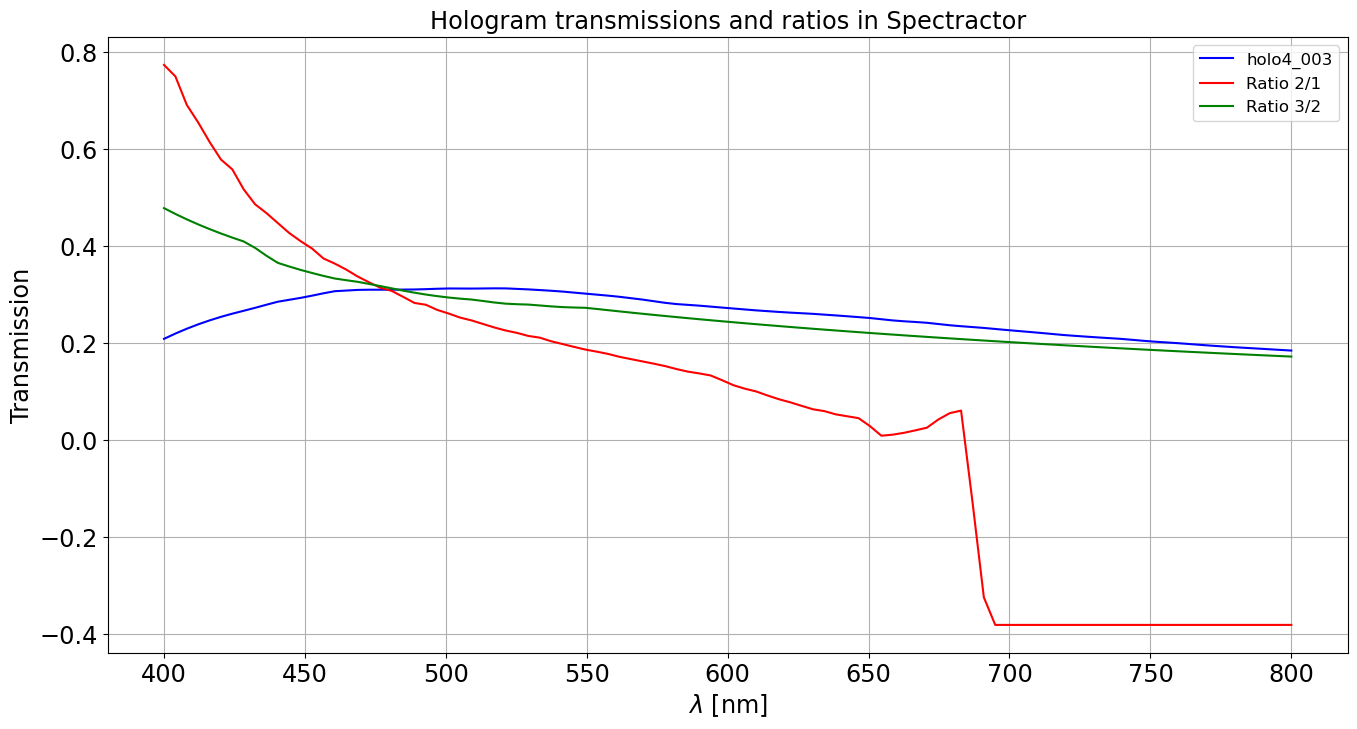

In [79]:
spectrum.disperser.plot_transmission(xlim=(400,800))
plt.title("Hologram transmissions and ratios in Spectractor")

## Ask spectrum for the dispersion relation

In [80]:
spectrum.disperser.N([2000.,300.])

150.0

In [81]:
spectrum.disperser.load_specs()

## Fix the pixel grid and pixel range 

In [82]:
pix_distance=np.arange(1,3000)

In [83]:
spectrum_lambdas = spectrum.disperser.grating_pixel_to_lambda(pix_distance, spectrum.x0, order=spectrum.order)

In [84]:
# spectrum.lambdas_binwidths = np.gradient(spectrum.lambdas)   # probably dlambda/dNpix (pix)
# assume spectrum.lambdas be regular in pixel, this may not be the case

In [85]:
spectrum_lambdas_binwidth = spectrum.lambdas_binwidths
1/spectrum_lambdas_binwidth

array([1.41724018, 1.41721934, 1.41717805, ..., 1.46346629, 1.4635412 ,
       1.46357867])

In [86]:
dispersers.get_theta0(spectrum.x0)

-0.0007830777460619689

In [87]:
dispersers.get_theta0([1000.,8])

0.0

Text(0.5, 1.0, 'Spectrum : Pixel vs wavelength calibration')

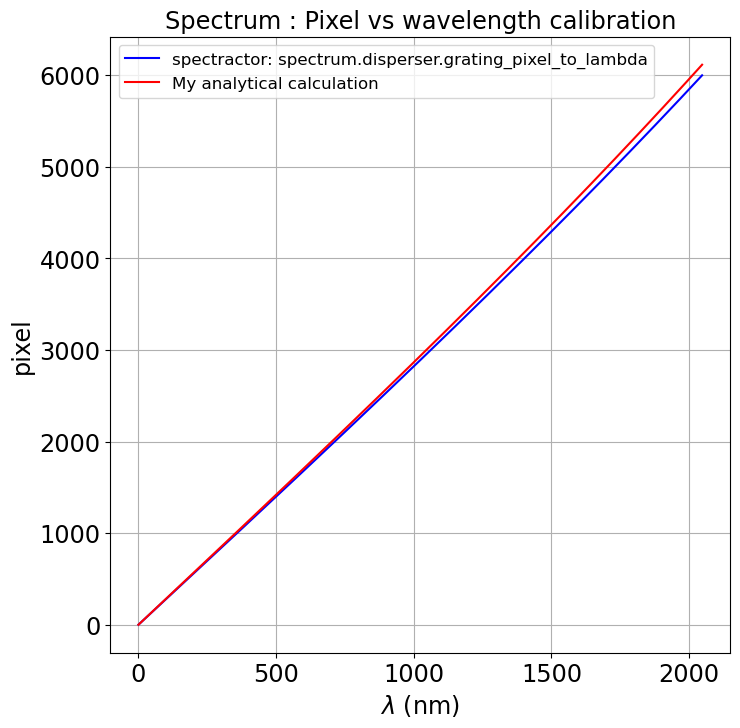

In [88]:
%matplotlib inline
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.plot(spectrum_lambdas,pix_distance*REBIN,'b-',label="spectractor: spectrum.disperser.grating_pixel_to_lambda")
my_x_pix = Dispersion(spectrum_lambdas*1e-6,neff,DCCD)/PIXELW   # pixel per nm
ax.plot(spectrum_lambdas,my_x_pix,'r-',label="My analytical calculation")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("pixel")
ax.grid()
ax.legend()
ax.set_title("Spectrum : Pixel vs wavelength calibration")

Text(0.5, 1.0, 'Spectrum : Pixel gradient vs wavelength calibration')

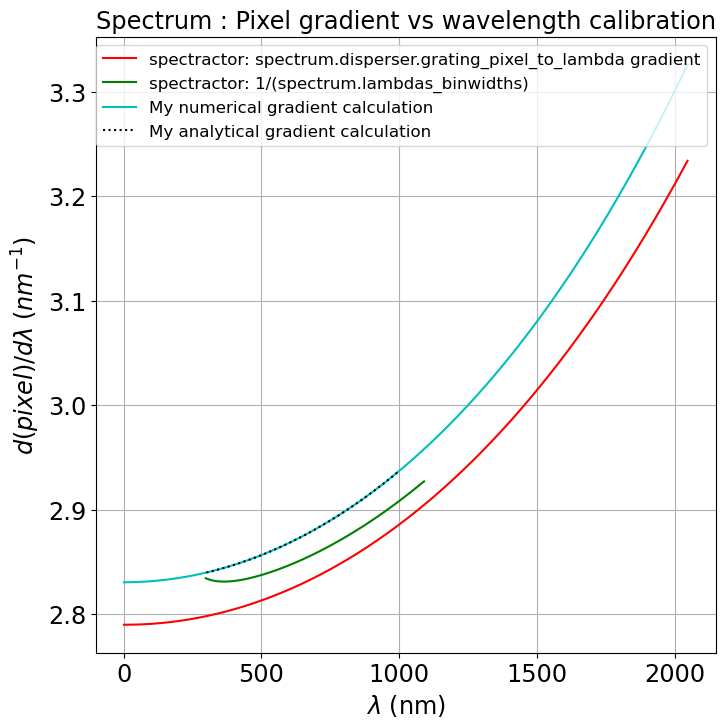

In [89]:
%matplotlib inline
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.plot(spectrum_lambdas,np.gradient(pix_distance*REBIN,spectrum_lambdas),'r-',label="spectractor: spectrum.disperser.grating_pixel_to_lambda gradient")
ax.plot(spectrum.lambdas,REBIN/spectrum.lambdas_binwidths,"g",label="spectractor: 1/(spectrum.lambdas_binwidths)")
ax.plot(spectrum_lambdas,np.gradient(my_x_pix,spectrum_lambdas),'c-',label="My numerical gradient calculation")
ax.plot(WL, Y2,"k:",label="My analytical gradient calculation")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("$d(pixel)/d\lambda \; (nm^{-1})$")
ax.legend()
ax.grid()
ax.set_title("Spectrum : Pixel gradient vs wavelength calibration")

### Nanometers per pixels

In [90]:
spectrum.lambdas_binwidths/REBIN

array([0.35279835, 0.35280354, 0.35281382, ..., 0.34165461, 0.34163712,
       0.34162837])

### Number of pixels per nm 

In [91]:
REBIN/spectrum.lambdas_binwidths

array([2.83448035, 2.83443868, 2.8343561 , ..., 2.92693257, 2.92708241,
       2.92715735])

In [92]:
spectrum.lambdas

array([ 297.86801798,  298.57361468,  299.27923213, ..., 1088.87407064,
       1089.55736237, 1090.24061911])

# Try to recalibrate in wavelegth

In [93]:
wavelength_array = calibrate_spectrum(spectrum, with_adr=True)

In [94]:
wavelength_array 

array([ 297.86231486,  298.56796526,  299.2736359 , ..., 1088.87766702,
       1089.56096042, 1090.24421884])

In [95]:
pixel_grid = spectrum.disperser.grating_lambda_to_pixel(wavelength_array , x0=[0,0], order=1)

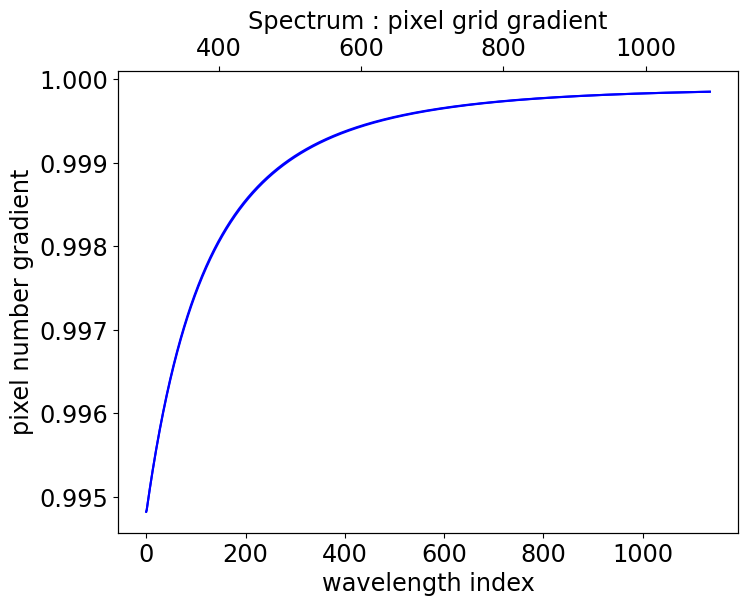

In [96]:
%matplotlib inline
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(111)
ax.plot(np.gradient(pixel_grid),"b-")
ax.set_xlabel("wavelength index")
ax.set_ylabel("pixel number gradient")
ax.set_title("Spectrum : pixel grid gradient")
ax2 = ax.twiny()
ax2.plot(wavelength_array,np.gradient(pixel_grid),"b-")

In [97]:
my_lambdas = spectrum.disperser.grating_pixel_to_lambda(pix_distance, spectrum.x0, order=spectrum.order)

Text(0.5, 1.0, 'Spectrum : Pixel vs wavelength calibration')

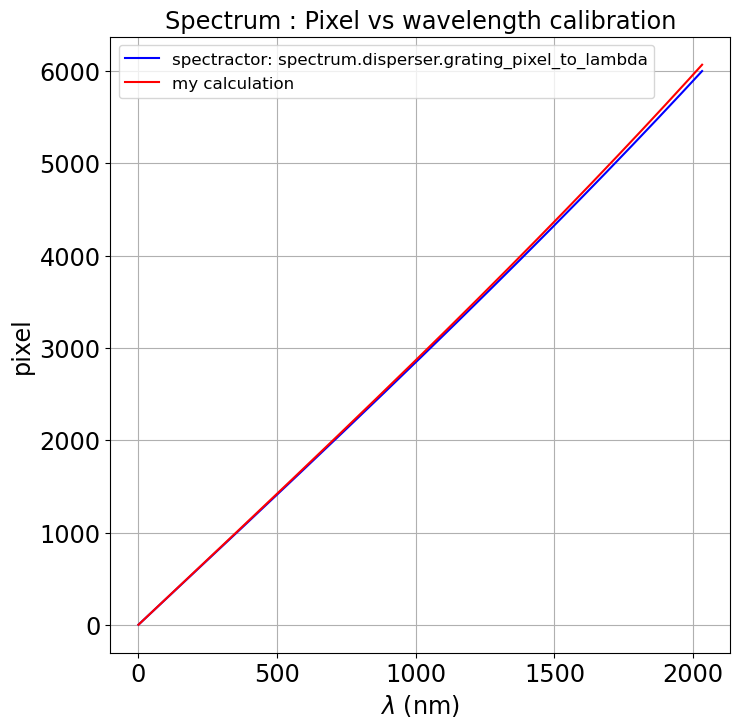

In [98]:
%matplotlib inline
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.plot(my_lambdas,pix_distance*REBIN,'b-',label="spectractor: spectrum.disperser.grating_pixel_to_lambda")
x_pix = Dispersion(my_lambdas*1e-6,neff,DCCD)/PIXELW   # pixel per nm
ax.plot(my_lambdas,x_pix,'r-',label="my calculation")
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("pixel")
ax.grid()
ax.legend()
ax.set_title("Spectrum : Pixel vs wavelength calibration")

# My spectrum calculation from Table

- $S_\lambda(\lambda)$ : SED in erg/cm2/s/nm
- FLAM to ADU
$$
\frac{dN_{ADU}(\lambda)}{dN_{pix}} = \left( \frac{S \Delta T \epsilon_{eq}(\lambda)}{G_{el}} \right) \frac{1}{hc} \lambda \frac{d\lambda}{dN_{pix}} \cdot S_\lambda(\lambda)
$$

- ADU to FLAM

$$
S_\lambda(\lambda) = \frac{dn_\gamma(\lambda)}{d\lambda} = \frac{G_{el}}{S\Delta T \epsilon_{QE}(\lambda)} (hc) \frac{1}{\lambda} \left( \frac{dN_{pix}}{d\lambda}\right) \left(\frac{dN_{ADU}}{dN_{pix}} \right)
$$


- FLAM to ADU constant:
$$
FLAM\_TO\_ADURATE = \left( \frac{S}{G_{el}} \right) \frac{1}{hc} \times \left[ TIME \right ]_{unit}  \times \left[ \lambda d\lambda \right]_{unit}
\times \left[ SED \right ]_{unit} 
$$

In [99]:
import astropy.units as units
from astropy import constants as const

In [100]:
# spectrum.lambdas_binwidths = np.gradient(spectrum.lambdas)   # probably dlambda/dNpix (pix)
# ldl = parameters.FLAM_TO_ADURATE * self.lambdas * np.abs(self.lambdas_binwidths)
# self.data /= ldl

In [101]:
parameters.FLAM_TO_ADURATE

5175865186660.421

In [102]:
parameters.OBS_DIAMETER  # OK

<Quantity 1.2 m>

In [103]:
(parameters.OBS_DIAMETER)**2/4*np.pi

<Quantity 1.13097336 m2>

In [104]:
parameters.OBS_SURFACE # OK

<Quantity 1.13097336 m2>

In [105]:
parameters.CCD_GAIN # OK

1.1

In [106]:
parameters.hc  # OK

<Quantity 1.98644586e-25 J m>

In [107]:
# Conversion factor
# Units of SEDs in flam (erg/s/cm2/nm) :
SED_UNIT = 1 * units.erg / units.s / units.cm ** 2 / units.nanometer
TIME_UNIT = 1 * units.s  # flux for 1 second
hc = const.h * const.c  # h.c product of fontamental constants c and h
wl_dwl_unit = units.nanometer ** 2  # lambda.dlambda  in wavelength in nm
FLAM_TO_ADURATE = ((parameters.OBS_SURFACE * SED_UNIT * TIME_UNIT * wl_dwl_unit / hc / parameters.CCD_GAIN).decompose()).value

In [108]:
FLAM_TO_ADURATE

5175865186660.421

In [109]:
# my calculation of the spectrum
my_spectrum = table.flux_sum / parameters.FLAM_TO_ADURATE/table.lambdas * np.gradient(table.Dx,table.lambdas)

Text(0.5, 1.0, 'Comparison Spectra : Spectrum calculation and my calculation')

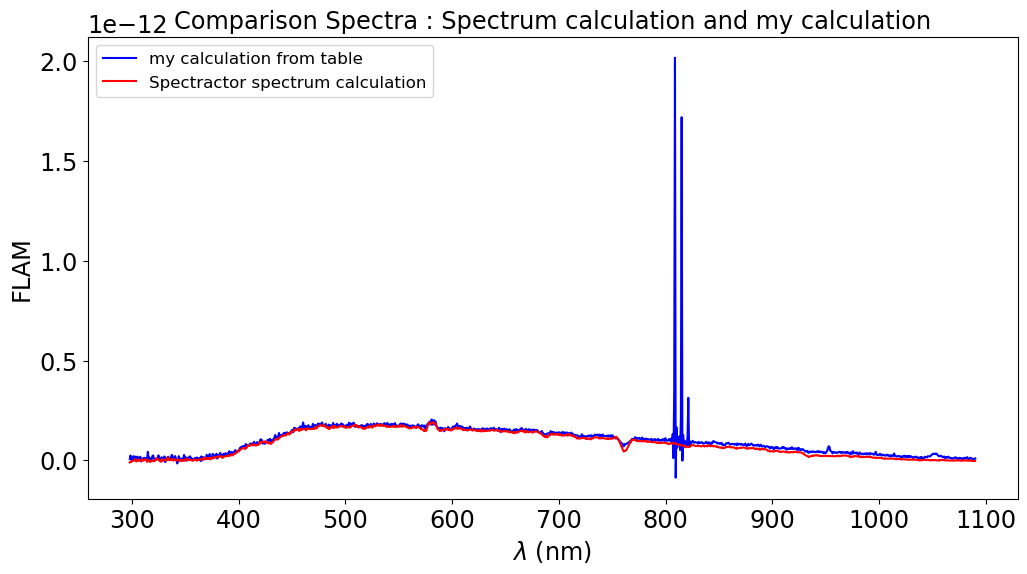

In [110]:
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)
ax.plot(table.lambdas,my_spectrum,color="b",label="my calculation from table")
ax.plot(spectrum.lambdas,spectrum.data,color="r",label="Spectractor spectrum calculation")
ax.legend()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("FLAM")
ax.set_title("Comparison Spectra : Spectrum calculation and my calculation")